In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import joblib

# Set random seed for reproducibility
np.random.seed(42)

# 1. Data Loading and Exploration
# Load the dataset
data = pd.read_csv('data.csv')
print(data)


     footfall  tempMode  AQ  USS  CS  VOC  RP  IP  Temperature  fail
0           0         7   7    1   6    6  36   3            1     1
1         190         1   3    3   5    1  20   4            1     0
2          31         7   2    2   6    1  24   6            1     0
3          83         4   3    4   5    1  28   6            1     0
4         640         7   5    6   4    0  68   6            1     0
..        ...       ...  ..  ...  ..  ...  ..  ..          ...   ...
939         0         7   7    1   6    4  73   6           24     1
940         0         7   5    2   6    6  50   6           24     1
941         0         3   6    2   7    5  43   6           24     1
942         0         6   6    2   5    6  46   7           24     1
943        18         7   4    2   6    3  61   7           24     1

[944 rows x 10 columns]


In [2]:
# Display basic information
print("Dataset Info:")
print(data.info())
print("\nFirst 5 rows:")
print(data.head())
print("\nSummary Statistics:")
print(data.describe())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 944 entries, 0 to 943
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   footfall     944 non-null    int64
 1   tempMode     944 non-null    int64
 2   AQ           944 non-null    int64
 3   USS          944 non-null    int64
 4   CS           944 non-null    int64
 5   VOC          944 non-null    int64
 6   RP           944 non-null    int64
 7   IP           944 non-null    int64
 8   Temperature  944 non-null    int64
 9   fail         944 non-null    int64
dtypes: int64(10)
memory usage: 73.9 KB
None

First 5 rows:
   footfall  tempMode  AQ  USS  CS  VOC  RP  IP  Temperature  fail
0         0         7   7    1   6    6  36   3            1     1
1       190         1   3    3   5    1  20   4            1     0
2        31         7   2    2   6    1  24   6            1     0
3        83         4   3    4   5    1  28   6            1     0
4     

In [3]:
# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())



Missing Values:
footfall       0
tempMode       0
AQ             0
USS            0
CS             0
VOC            0
RP             0
IP             0
Temperature    0
fail           0
dtype: int64


In [4]:
# Check class distribution
print("\nClass Distribution:")
print(data['fail'].value_counts(normalize=True))




Class Distribution:
fail
0    0.583686
1    0.416314
Name: proportion, dtype: float64


In [5]:
# 2. Data Visualization
plt.figure(figsize=(15, 10))


<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

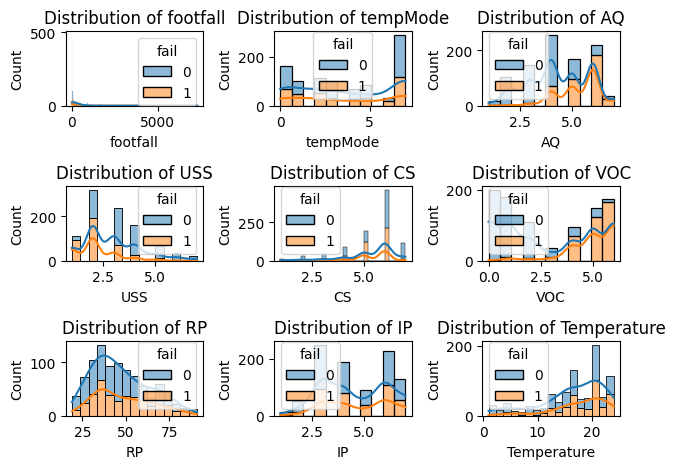

In [6]:
# Plot histograms for each feature
for i, column in enumerate(data.columns[:-1]):  # Exclude the target variable
    plt.subplot(3, 3, i+1)
    sns.histplot(data=data, x=column, hue='fail', kde=True, multiple='stack')
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()


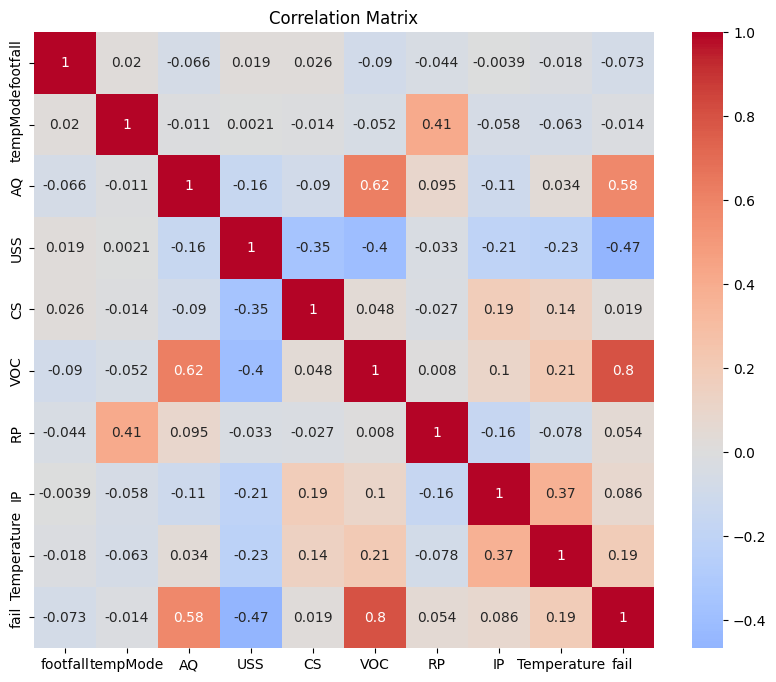

In [7]:
# Correlation matrix
plt.figure(figsize=(10, 8))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()


In [8]:
# 3. Data Preprocessing
# Separate features and target
X = data.drop('fail', axis=1)
y = data['fail']


In [9]:
# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)


In [11]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [12]:
# 4. Model Training
# Initialize Random Forest Classifier
rf = RandomForestClassifier(random_state=42)


In [13]:
# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


In [14]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                          cv=5, n_jobs=-1, verbose=2, scoring='roc_auc')
grid_search.fit(X_train_scaled, y_train)

# Get the best model
best_rf = grid_search.best_estimator_


Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [15]:
# 5. Model Evaluation
# Make predictions
y_pred = best_rf.predict(X_test_scaled)
y_pred_proba = best_rf.predict_proba(X_test_scaled)[:, 1]


In [16]:
# Evaluate the model
print("\nBest Parameters:", grid_search.best_params_)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))



Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.92       111
           1       0.91      0.94      0.92       110

    accuracy                           0.92       221
   macro avg       0.92      0.92      0.92       221
weighted avg       0.92      0.92      0.92       221


Confusion Matrix:
[[101  10]
 [  7 103]]

Accuracy Score: 0.9230769230769231
ROC AUC Score: 0.9817362817362817


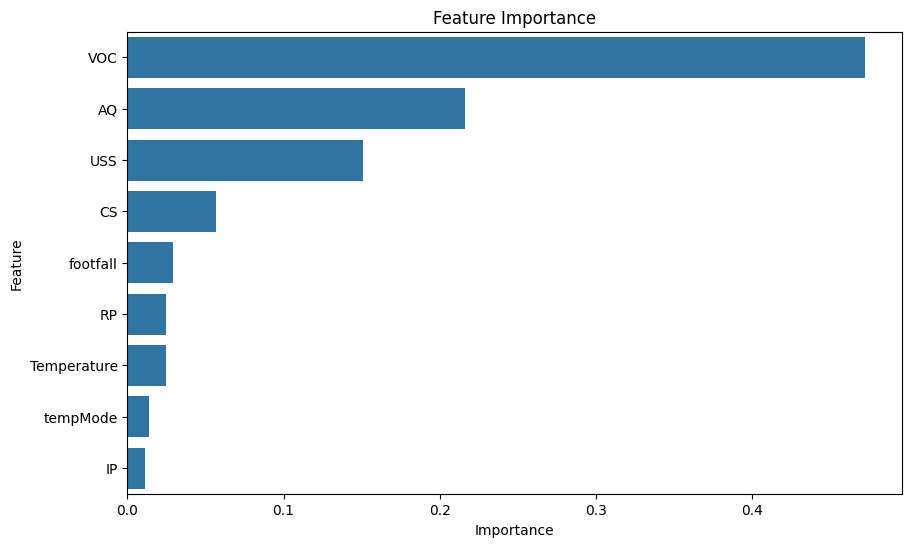

In [17]:
# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()


In [19]:
# 6. Model Deployment (Optional)
# Save the trained model and scaler for future use
joblib.dump(best_rf, 'machine_failure_rf_model.pkl')
joblib.dump(scaler, 'machine_failure_scaler.pkl')


['machine_failure_scaler.pkl']